# GPs with cellij
from: https://pyro.ai/examples/gp.html

In [9]:
import torch
import gpytorch
import pyro # pyro-ppl
import pandas as pd
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap # umap-learn
import muon as mu
import os
from os import path
import io
from sklearn.decomposition import PCA
import anndata
import pickle
import dill

import matplotlib
pyro.set_rng_seed(0)


In [3]:
data = pd.read_csv("/Users/tim.treis/Downloads/guo2010_qpcr.csv", sep=",", index_col=0)

modalities = {}
cell_labels = data.index.values.tolist()
data.index = [i.replace(" ", "_") for i in data.index.values.tolist()]
data.index = [f"obs{idx}_{name}" for name, idx in zip(data.index, range(len(data.index)))]
modalities["qPCR"] = anndata.AnnData(X=data, dtype="float32")

mdata = mu.MuData(modalities)
metadata = pd.DataFrame()
metadata["n_cells"] = [int(label.split(" ")[0]) for label in cell_labels]
metadata["label"] = [label.split(" ")[1] if len(label.split(" ")) == 2 else None for label in cell_labels]
metadata["division"] = np.log2(metadata["n_cells"]).astype(int)
metadata["division_scaled"] = metadata["division"] / 6
metadata.index = mdata.obs.index
mdata.obs = mdata.obs.join(metadata)
mdata.obs

,n_cells,label,division,division_scaled
obs0_1,1,None,0,0.0
obs1_1,1,None,0,0.0
obs2_1,1,None,0,0.0
obs3_1,1,None,0,0.0
obs4_1,1,None,0,0.0
...,...,...,...,...
obs432_64_TE,64,TE,6,1.0
obs433_64_TE,64,TE,6,1.0
obs434_64_TE,64,TE,6,1.0
obs435_64_TE,64,TE,6,1.0


In [5]:
def add_label_color(df):
    df["label"] = mdata.obs.label.values
    label_set = set(df["label"]) - {None}
    num_labels = len(label_set)
    color_map = matplotlib.cm.colors.ListedColormap( sns.color_palette("colorblind", num_labels))
    label_to_color = {label: color_map(i) for i, label in enumerate(label_set)}
    colors = [label_to_color[label] if label in label_to_color else 'gray' for label in means_ls2_nogp["label"]]
    df["label_c"] = colors
    
    return df

ValueError: keyword labelweight is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

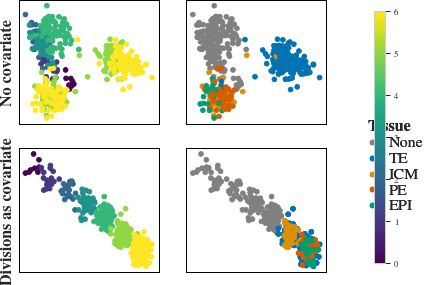

In [10]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")
# sns.set_palette(sns.color_palette("colorblind", 9))
sns.set_palette(sns.color_palette("viridis", 9))
plt.rcParams["figure.constrained_layout.use"] = False
plt.rcParams["figure.autolayout"] = False
# plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.015

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

means_ls2_nogp = dill.load(open("/Users/tim.treis/Downloads/NoGP_ls2.5_2factors_factors.pkl", 'rb'))
means_ls2_nogp = pd.DataFrame(means_ls2_nogp.T, index=mdata.obs.index)
means_ls2_nogp.columns = [f"factor{i}" for i in range(means_ls2_nogp.shape[1])]
means_ls2_nogp["time"] = mdata.obs["division"]
means_ls2_nogp = add_label_color(means_ls2_nogp)


means_ls2_1D = dill.load(open("/Users/tim.treis/Downloads/1D_ls2.5_factors.pkl", 'rb'))
# means_ls2_1D = dill.load(open("/Users/tim.treis/Downloads/1D_ls2_2factors_factors.pkl", 'rb'))
means_ls2_1D = pd.DataFrame(means_ls2_1D.T, index=mdata.obs.index)
means_ls2_1D.columns = [f"factor{i}" for i in range(means_ls2_1D.shape[1])]
means_ls2_1D["time"] = mdata.obs["division"]
means_ls2_1D = add_label_color(means_ls2_1D)

fig, axs =  plt.subplots(2, 2, figsize=(5.5, 5))

fontsize = 16
plt.rc('font', size=fontsize)

# Adjust the legend label spacing globally
matplotlib.rcParams['legend.labelspacing'] = 0.1
matplotlib.rcParams['legend.handletextpad'] = 0.03  # Modify the handle text padding


axs[0,0].scatter(means_ls2_nogp["factor0"], means_ls2_nogp["factor1"], c=means_ls2_nogp["time"], cmap="viridis")
im = axs[1,0].scatter(means_ls2_1D["factor0"], means_ls2_1D["factor1"], c=means_ls2_1D["time"], cmap="viridis")
axs[0,1].scatter(means_ls2_nogp["factor0"], means_ls2_nogp["factor1"], c=means_ls2_nogp["label_c"], cmap="colorblind")
axs[1,1].scatter(means_ls2_1D["factor0"], means_ls2_1D["factor1"], c=means_ls2_1D["label_c"], cmap="colorblind")

means_ls2_nogp["label"] = [str(l) for l in means_ls2_nogp["label"]]

for lab in means_ls2_1D["label"].unique():
    tmp = means_ls2_1D.query(f"label == '{lab}'")
    c = "grey" if lab is None else tmp["label_c"]
    axs[1,1].scatter(tmp["factor0"], tmp["factor1"], c = c, label=str(lab))
    # axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    
axs[0,0].set_ylabel("No covariate", fontsize=fontsize, fontweight=600)
axs[1,0].set_ylabel("Divisions as covariate", fontsize=fontsize, fontweight=600)

# axs[1,1].legend(loc='center', bbox_to_anchor=(2, 0.5), title="tissue", frameon=False)

legend_labels = means_ls2_1D["label"].unique()
legend_colors = means_ls2_1D["label_c"].unique()
legend_handles = []
for i, label in enumerate(legend_labels):
    label = str(label)
    legend_handles.append(plt.scatter([], [], color=legend_colors[i], label=label))
legend = plt.legend(handles=legend_handles, loc='upper right', frameon=False, bbox_to_anchor=(1.8, 1.35), fontsize=fontsize)
legend.set_title("Tissue", prop={'size': fontsize, "weight": 600})
plt.gca().add_artist(legend)

cbar_ax = fig.add_axes([1.02, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=fontsize, labelweight=600)
label_text = 'Divisions'
cbar.ax.text(-0.75, 6.4, label_text, rotation=0, va='center', fontweight=600)
# plt.colorbar(axs[0,0].collections[0], ax=axs[0,0])
plt.tight_layout()
plt.savefig("/Users/tim.treis/Downloads/gp.pdf", bbox_inches='tight')

In [5]:
# imp = cellij.core.Importer()
# mdata = imp.load_Guo2010()
# adata = mdata["qPCR"]
# data = adata.to_df()
# time = mdata.obs["division_scaled"]

imp = cellij.core.Importer()
mdata = imp.load_MEFISTO()
adata = mdata["view1"]
data = adata.to_df()
time = np.linspace(0, 1, data.shape[0])

NameError: name 'cellij' is not defined

In [11]:
means_ls2_1D

,factor0,factor1,factor2,factor3,time,label,label_c
obs0_1,-0.002313,0.002777,-0.002600,-0.004559,0,None,gray
obs1_1,-0.002132,0.002817,-0.002494,-0.004493,0,None,gray
obs2_1,-0.002095,0.002806,-0.002415,-0.004655,0,None,gray
obs3_1,-0.002344,0.002749,-0.002445,-0.004560,0,None,gray
obs4_1,-0.002250,0.003001,-0.002334,-0.004627,0,None,gray
...,...,...,...,...,...,...,...
obs432_64_TE,0.000004,0.001548,-0.002561,-0.004921,6,TE,"(0.00392156862745098, 0.45098039215686275, 0.6..."
obs433_64_TE,0.000132,0.001792,-0.002534,-0.005035,6,TE,"(0.00392156862745098, 0.45098039215686275, 0.6..."
obs434_64_TE,0.000109,0.001692,-0.002531,-0.005012,6,TE,"(0.00392156862745098, 0.45098039215686275, 0.6..."
obs435_64_TE,0.000113,0.001621,-0.002424,-0.005136,6,TE,"(0.00392156862745098, 0.45098039215686275, 0.6..."


In [ ]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, n_factors, init_lengthscale=5.,): 
        n_inducing = len(inducing_points)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=n_inducing, batch_shape = torch.Size([n_factors]),
            )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            model=self, 
            inducing_points=torch.tensor(
                data=inducing_points,
                dtype=torch.float32
            ), 
            variational_distribution=variational_distribution, 
            learn_inducing_locations=False,
        )

        super().__init__(variational_strategy=variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean(
            batch_shape=torch.Size([n_factors]),
            )
        self.kernel = gpytorch.kernels.RBFKernel(batch_shape = torch.Size([n_factors]))
        self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
        self.covar_module.base_kernel.lengthscale = init_lengthscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
class MEFISTO(gpytorch.Module):
    def __init__(
        self,
        data,
        time,
        n_factors,
    ):
        super().__init__()

        self.n_factors = n_factors
        self.data = data
        self.time = time
        self.n_obs = self.data.shape[0]
        self.n_features = self.data.shape[1]
        self.unique_time = torch.linspace(self.time.min(), self.time.max(), int(self.n_obs/40)).float()
        
        self.plates = {
            "obs": pyro.plate("obs", self.n_obs, dim=-1),
            "factors": pyro.plate("factors", n_factors, dim=-2),
            "features": pyro.plate("features", self.n_features, dim=-3),
        }
        
        self.gp = GPModel(
            inducing_points=self.time,
            n_factors=self.n_factors
        )
        
        # self.w_init = _init_pca(self.time, 0) # Initialise X to PCA
        
    def model(self):
        pyro.module("gp", self)
        
        with self.plates["features"], self.plates["factors"]:
            w = pyro.sample(
                "w", 
                dist.Normal(torch.tensor(0.0), torch.tensor(1.0))
            ).view(-1, self.n_features, self.n_factors, 1)

        with self.plates["factors"], self.plates["obs"]:
            z = pyro.sample(
                    "z",
                    self.gp.pyro_model(self.time),
                ).view(-1, 1, self.n_factors, self.n_obs)
        
        prod = torch.matmul(
            input=w.squeeze(),
            other=z.squeeze(),
        ).view(-1, self.n_features, 1, self.n_obs)

        with self.plates["features"], self.plates["obs"]:
            pyro.sample(
                name='obs',
                fn=dist.Normal(prod, 1.),
                obs=self.data.T.view(-1, self.n_features, 1, self.n_obs),
            )

    def guide(self):
        w_loc = pyro.param('w_loc',  init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=0.0,
                dtype=torch.float32,
            ).view(-1, self.n_features, self.n_factors, 1))
        w_scale = pyro.param('w_scale', init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=1.0,
                dtype=torch.float32,
            ).view(-1, self.n_features, self.n_factors, 1))

        with self.plates["features"], self.plates["factors"]:
            pyro.sample(
                "w", 
                dist.Normal(w_loc, w_scale)
            )
            
        with self.plates["factors"], self.plates["obs"]:
            pyro.sample(
                    "z",
                    self.gp.pyro_guide(self.time),
            )
            
    def inference(self, num_particles=15, max_epochs=1000):
        self.optimizer = pyro.optim.Adam({"lr": 1e-3})

        elbo = pyro.infer.Trace_ELBO(
            retain_graph=True,
            num_particles=num_particles,
            vectorize_particles=True,
        )

        svi = pyro.infer.SVI(
            model=self.model,
            guide=self.guide,
            optim=self.optimizer,
            loss=elbo,
        )

        self.train()
        self.losses = []
        for epoch in range(max_epochs):
            self.zero_grad()
            loss = svi.step()
            self.losses.append(loss)
            if epoch % 10 == 0:
                print(epoch, loss)
                
    def get_factors(
        self,
        n_samples: int=25,
        ) -> torch.tensor:
        """Get the inferred means of the factors.
        
        Args:
            n_samples: number of samples to use for mean estimate

        Returns:
            tensor of shape (n_cells, n_factors, res, res)
        """
        self.eval()
        
        factor_means = []
        with torch.no_grad():
            dist = self.gp(self.unique_time)
            samples = dist(torch.Size([n_samples])).cpu()
            mean = samples.mean(dim=0)
            mean = torch.transpose(mean, -1, -2)
            factor_means.append(torch.transpose(mean, -1, -2))

        factor_means = torch.stack(factor_means, dim=0)

        self.train()

        return factor_means


In [ ]:


model = MEFISTO(data=torch.tensor(data.values), time=torch.tensor(time).float(), n_factors=4)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_25676/214542631.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points=torch.tensor(


In [ ]:
model.inference(num_particles=10, max_epochs=300)

0 106367.575
10 106852.46708984375
20 103482.90810546876
30 101010.13701171875
40 98304.31953125
50 93488.57744140625
60 92507.5728515625
70 90019.91455078125
80 87944.4703125
90 86023.9509765625
100 84853.97626953125
110 83342.766015625
120 84220.76494140625
130 81586.6673828125
140 80353.77958984375
150 79684.267578125
160 77482.20146484375
170 77374.3326171875
180 76422.8662109375
190 75668.07978515625
200 74930.166796875
210 73885.67294921874
220 73457.7662109375
230 72020.2697265625
240 71659.28349609375
250 70714.42412109375
260 70238.3841796875
270 70414.67099609374
280 69381.31904296875
290 69061.67529296875


In [ ]:
plt.plot(torch.arange(len(model.losses)), model.losses)

NameError: name 'plt' is not defined

tensor([[[-0.0007, -0.0008, -0.0009, -0.0010, -0.0011],
         [-0.0019, -0.0018, -0.0017, -0.0016, -0.0015],
         [-0.0011, -0.0009, -0.0007, -0.0005, -0.0003],
         [ 0.0013,  0.0011,  0.0010,  0.0009,  0.0007]]])


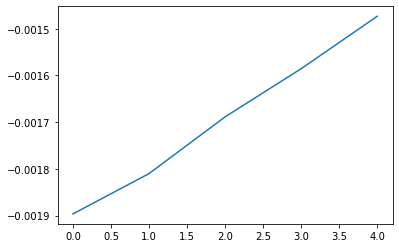

In [ ]:
d = model.get_factors(n_samples=1000000)
print(d)
plt.plot(d.squeeze()[1])

In [ ]:
pyro.get_param_store().keys()

dict_keys(['w_loc', 'w_scale', 'gp$$$gp.variational_strategy._variational_distribution.variational_mean', 'gp$$$gp.variational_strategy._variational_distribution.chol_variational_covar', 'gp$$$gp.kernel.raw_lengthscale', 'gp$$$gp.covar_module.raw_outputscale'])

<AxesSubplot:>

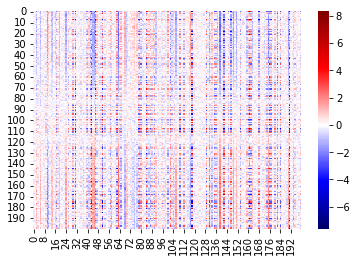

In [ ]:
sns.heatmap(data.to_numpy(), cmap="seismic", center=0)

<AxesSubplot:>

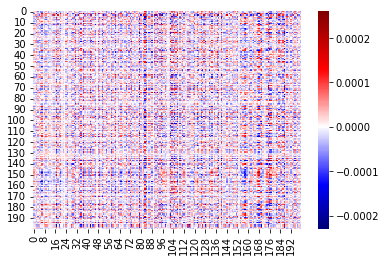

In [ ]:
a = pyro.param('gp$$$gp.variational_strategy._variational_distribution.variational_mean').detach().numpy()
b = pyro.param("w_loc").squeeze().detach().numpy()
sns.heatmap(b@a, center=0, cmap="seismic")

In [ ]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

test_x = torch.linspace(0, 1, 100).float()

model.eval()
with torch.no_grad():
    output = model.gp(test_x)

samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

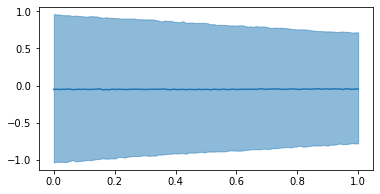

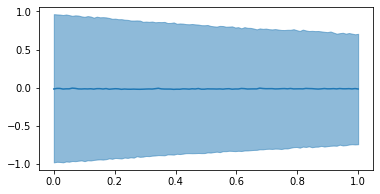

In [ ]:
for k in range(2):
    # visualize the result
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    line, = ax.plot(test_x, mean[k].detach().cpu().numpy(), label='GP prediction')
    ax.fill_between(
        test_x, lower[k].detach().cpu().numpy(),
        upper[k].detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )

In [ ]:
plt.plot(

SyntaxError: unexpected EOF while parsing (582913220.py, line 1)